# Import Libraries

In [1]:
import datasets
import transformers
import pandas as pd
import torch
import os
import csv
import ast
from torch.utils.data.dataset import Dataset
from pathlib import Path

#Tokenizer from scratch on vocabulary of corpus
from tokenizers import ByteLevelBPETokenizer

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

# Decoder
from transformers import RobertaConfig
from transformers import RobertaForMaskedLM # RobertaLM for learning
from transformers import RobertaTokenizerFast # After training tokenizern we will wrap it so it can be used by Roberta model


#Encoder-Decoder Model
from transformers import VisionEncoderDecoderModel

#Training
# When using previous version of the library you need the following two lines
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import Trainer, TrainingArguments

d:\Anaconda\envs\vitbilstm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Parameters for Training

In [2]:
TRAIN_BATCH_SIZE = 20   # input batch size for training (default: 64) 20
VALID_BATCH_SIZE = 5   # input batch size for testing (default: 1000) 5
VAL_EPOCHS = 1 
LEARNING_RATE = 1e-4    # learning rate (default: 0.01) 1e-4
SEED = 42               # random seed (default: 42)
MAX_LEN = 128           # Max length for product description
SUMMARY_LEN = 20         # Max length for product names

TRAIN_EPOCHS = 10       # number of epochs to train (default: 10)
WEIGHT_DECAY = 0.01
SEED = 42               # random seed (default: 42)
MAX_LEN = 128
SUMMARY_LEN = 20   # Maximum length of caption generated by the model

# Preparing the Dataset

In [3]:
import os
os.chdir(r'D:/Downloads/ML/Image_Captioning_using_Hugging_Face-main/Image_Captioning_using_Hugging_Face-main')
import json


with open('data.json', 'r') as openfile:

    json_object = json.load(openfile)

images_caption_dict = dict(json_object)


images_path = 'D:/Downloads/ML/flickr8k/Images'
images = list(images_caption_dict.keys())

for image_path in images:
    if image_path.endswith('jpg'):
        new = images_path + '/' + image_path.split('/')[-1]
        images_caption_dict[new] = images_caption_dict.pop(image_path)
    else:
        images_caption_dict.pop(image_path)

# Encoder (ViT) -  Decoder (Roberta)

### Train Test Split

In [4]:
import random 
def train_test_split(dictionary):
    images = sorted(dictionary.keys())
    images_test = random.sample(images,int(0.3*len(images)))
    images_train = [img for img in images if img not in images_test]

    train_dict = {
      img: dictionary[img] for img in images_train
    }

    test_dict = {
      img: dictionary[img] for img in images_test
    }
    return(train_dict,test_dict)

train,test = train_test_split(images_caption_dict)

### Creating Dataframe for Training

In [5]:
import pandas as pd

def get_df(dictionary):
    df = pd.DataFrame([])

    captions = []
    images = []
    for image in list(images_caption_dict.keys()):
        caption = images_caption_dict[image]
    #     captions.append(('.'.join([ sent.rstrip() for sent in ('.'.join(caption)).split('<e>.<s>')]))\
    #                             .replace('<s> ','').replace('  <e>','.'))
        for capt in caption:
            captions.append(' '.join(capt.replace('<s> ','').replace('  <e>','').strip().split(' ')[:30]))
            images.append(image)

    df['images'] = images
    df['captions'] = captions
    return(df)

train_df = get_df(train)
test_df = get_df(test)

### Intializing Decoder Tokenizer

In [6]:
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained('Byte_tokenizer', max_len=MAX_LEN)

### Intializing ViT Feature Extractor

In [7]:
from transformers import ViTFeatureExtractor, ViTModel
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

d:\Anaconda\envs\vitbilstm\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


### Creating Dataset for training (The number of training samples wre limited due to processing restrictions)

In [8]:
import torch
from torch.utils.data import Dataset
from PIL import Image

batch_size=TRAIN_BATCH_SIZE  # change to 16 for full training

class IAMDataset(Dataset):
    def __init__(self, df, tokenizer,feature_extractor, decoder_max_length=31):
        self.df = df
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.decoder_max_length = decoder_max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        img_path = self.df['images'][idx]
        caption = self.df['captions'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(img_path).convert("RGB")
        pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.tokenizer(caption, truncation = True,
                                          padding="max_length", 
                                          max_length=self.decoder_max_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding
    
train_dataset = IAMDataset(df=train_df.sample(frac=0.3,random_state=2).iloc[:10000].reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,
                          feature_extractor= feature_extractor)
eval_dataset = IAMDataset(df=test_df.sample(frac=0.1,random_state=2)[:2000].reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,feature_extractor= feature_extractor)


## Using VisonEncoderDecoder for connecting the Encoder & Decoder model.
#### tie_encoder_decoder - is used to create a cross attention head connection.

In [10]:
# set encoder decoder tying to True
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained\
                    ("google/vit-base-patch16-224-in21k", 'RobertaMLM', tie_encoder_decoder=True)

: 

#### Setting parameters of the Captioning model with the attributes of pretrained models

In [11]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 20
# model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

NameError: name 'model' is not defined

### Defining Metrics to evaluate the performance

In [11]:
%pip install evaluate
%pip install rouge-score
%pip install nltk
%pip install absl-py
import evaluate

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
# load rouge for validation
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }


C:\Users\vaibh\AppData\Local\Temp\ipykernel_2444\3071510440.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = datasets.load_metric("rouge")


### Training Image Captioning model


In [13]:
captioning_model = 'VIT_Captioning'

training_args = Seq2SeqTrainingArguments(
    output_dir=captioning_model,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    #evaluate_during_training=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,  
    #max_steps=1500, # delete for full training
    num_train_epochs = TRAIN_EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)

from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

In [15]:
# Fine-tune the model, training and evaluating on the train dataset
trainer.train()

 41%|████      | 2048/5000 [20:27:00<29:28:36, 35.95s/it]

## Saving

In [ ]:
trainer.save_model('Image_Cationing_VIT_Roberta_iter2')

## Loading and Evaluating performance

In [9]:
t = VisionEncoderDecoderModel.from_pretrained('Image_Cationing_VIT_Roberta_iter2')

The following encoder weights were not tied to the decoder ['vision_encoder_decoder/encoder', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/pooler', 'vision_encoder_decoder/embeddings']
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/encoder', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/pooler', 'vision_encoder_decoder/embeddings']
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/encoder', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/pooler', 'vision_encoder_decoder/embeddings']


D:/Downloads/ML/flickr8k/Images/3405759441_fb31c80240.jpg


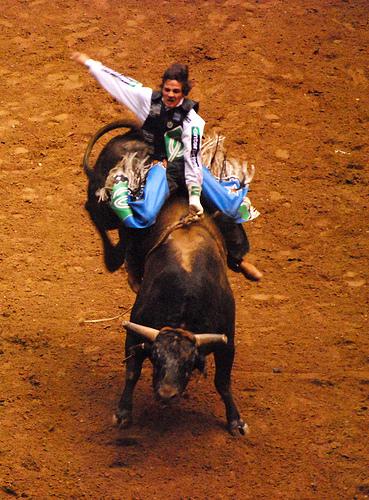

In [10]:
temp = test_df.sample(1).images.iloc[0]
print(temp)
Image.open(temp).convert("RGB")

In [11]:
f = tokenizer.decode(t.generate(feature_extractor(Image.open(temp).convert("RGB"), return_tensors="pt").pixel_values)[0])

d:\Anaconda\envs\vitbilstm\lib\site-packages\transformers\generation\utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [12]:
f[6:-4]

'a man in a blue shirt is standing on a rock in the air'

In [19]:
generate_captions_from_this_file = "Images.csv"
generate_captions_from_this_file_pd = pd.read_csv(generate_captions_from_this_file)
results = {}

for index, row in generate_captions_from_this_file_pd.iterrows():
    image = row['Image']
    predicted = tokenizer.decode(t.generate(feature_extractor(Image.open(image).convert("RGB"), return_tensors="pt").pixel_values)[0])[6:-4]
    results[image] = predicted

d:\Anaconda\envs\salesforce\Lib\site-packages\transformers\generation\utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [15]:
# save predicted captions to file
save_to = "ViT-Roberta.csv"
header = ["Image", "Caption"]

with open(save_to, 'w', newline = "") as file:
    csvwriter = csv.writer(file)
    csvwriter.writerow(header)
    for image, caption in results.items():
        row = [image, caption]
        csvwriter.writerow(row)

In [17]:
results = {}
dff = pd.read_csv(save_to)

for index, row in dff.iterrows():
    results[row['Image']] = row['Caption']

In [13]:
# loading the test dataset
test_captions = pd.read_csv("./flickr8k/test.csv")
images_folder = "./flickr8k/test"

In [14]:
# formation

images_set = set()
images_dict = {}
header = ['Image', 'Captions']
data = []

for index, row in test_df.iterrows():
    temp = []
    image = row['images']
    if image in images_set:
        continue
    caps = test_df[test_df['images'] == image]['captions'].values.tolist()
    images_set.add(image)
    images_dict[image] = caps
    temp.append(image)
    temp.append(caps)
    data.append(temp)

file_name = "ViT-Roberta.csv"
with open(file_name, 'w', newline="") as file:
    csvwriter = csv.writer(file)
    csvwriter.writerow(header)
    csvwriter.writerows(data)

In [19]:
MOD = 1e9 + 7
bleu1 = 0
bleu2 = 0
bleu3 = 0
bleu4 = 0
length = 1000
actual_captions_file = "Images.csv"
images_pd = pd.read_csv(actual_captions_file)

for index, row in images_pd.iterrows():
    true_captions = ast.literal_eval(row['Captions'])
    actual = [ele.split() for ele in true_captions]

    predicted = results[row['Image']].split()
    b1 = sentence_bleu(actual, predicted, weights=(1,0,0,0))
    b2 = sentence_bleu(actual, predicted, weights=(0.5,0.5,0,0))
    b3 = sentence_bleu(actual, predicted, weights=(0.3,0.3,0.3,0))
    b4 = sentence_bleu(actual, predicted, weights=(0.25,0.25,0.25,0.25))
    bleu1 = (bleu1 + b1) % MOD
    bleu2 = (bleu2 + b2) % MOD
    bleu3 = (bleu3 + b3) % MOD
    bleu4 = (bleu4 + b4) % MOD

print(f"BLEU-1 score: {(bleu1 / length) * 100}")
print(f"BLEU-2 score: {(bleu2 / length) * 100}")
print(f"BLEU-3 score: {(bleu3 / length) * 100}")
print(f"BLEU-4 score: {(bleu4 / length) * 100}")

d:\Anaconda\envs\vitbilstm\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
d:\Anaconda\envs\vitbilstm\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
d:\Anaconda\envs\vitbilstm\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  

BLEU-1 score: 42.535228589015965
BLEU-2 score: 23.89638145395366
BLEU-3 score: 12.952430480870406
BLEU-4 score: 3.5640707146419266


In [37]:
meteor = 0

for index, row in images_pd.iterrows():
    true_captions = ast.literal_eval(row['Captions'])
    actual = [ele.split() for ele in true_captions]

    predicted = results[row['Image']].split()
    print(f"Ref: {actual}")
    print(f"Cand: {predicted}")
    m = meteor_score(actual, predicted)
    meteor = (meteor + m) % MOD

print(f"METEOR score: {(meteor / length) * 100}")

Ref: [['a', 'group', 'of', 'four', 'children', 'wearing', 'pajamas', 'have', 'pillow', 'fight'], ['a', 'group', 'of', 'kids', 'have', 'pillow-fight'], ['a', 'group', 'of', 'young', 'children', 'playing', 'pillow', 'fight', 'on', 'bed'], ['children', 'having', 'pillow', 'fight'], ['four', 'children', 'are', 'having', 'pillow', 'fight']]
Cand: ['two', 'men', 'are', 'sitting', 'on', 'a', 'bench', 'in', 'a', 'field']
Ref: [['a', 'crowd', 'watching', 'air', 'balloons', 'at', 'night'], ['a', 'group', 'of', 'hot', 'air', 'balloons', 'lit', 'up', 'at', 'night'], ['people', 'are', 'watching', 'hot', 'air', 'balloons', 'in', 'the', 'park'], ['people', 'watching', 'hot', 'air', 'balloons'], ['seven', 'large', 'balloons', 'are', 'lined', 'up', 'at', 'nighttime', 'near', 'crowd']]
Cand: ['a', 'group', 'of', 'people', 'are', 'standing', 'in', 'a', 'field', 'of', 'a', 'building']
Ref: [['skiiers', 'walking', 'up', 'the', 'hill', 'through', 'forest'], ['two', 'men', 'are', 'skiing', 'in', 'the', 'snow

In [36]:
# calculating rouge metric

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_precision = 0
rouge1_recall = 0
rouge1_fmeasure = 0
rouge2_precision = 0
rouge2_recall = 0
rouge2_fmeasure = 0
rougeL_precision = 0
rougeL_recall = 0
rougeL_fmeasure = 0

length = 1000

obj = {
    'rouge1': [0, 0, 0],
    'rouge2': [0, 0, 0],
    'rougeL': [0, 0, 0]
}

for index, row in images_pd.iterrows():
    reference_captions = ast.literal_eval(row['Captions'])
    candidate_caption = results[row['Image']]
    print(f"Ref: {reference_captions}")
    print(f"Cand: {candidate_caption}")
    # reference_captions = captions
    # candidate_caption = tokenizer.decode(t.generate(feature_extractor(Image.open(image).convert("RGB"), return_tensors="pt").pixel_values)[0])[6:-4]
    scores = {key: [] for key in ['rouge1', 'rouge2', 'rougeL']}
    r1_p_max = 0
    r1_r_max = 0
    r1_f_max = 0
    r2_p_max = 0
    r2_r_max = 0
    r2_f_max = 0
    rL_p_max = 0
    rL_r_max = 0
    rL_f_max = 0
    for ref in reference_captions:
        temp_scores = scorer.score(ref, candidate_caption)
        r1_p_max = max(r1_p_max, temp_scores['rouge1'].precision)
        r1_r_max = max(r1_r_max, temp_scores['rouge1'].recall)
        r1_f_max = max(r1_f_max, temp_scores['rouge1'].fmeasure)

        r2_p_max = max(r2_p_max, temp_scores['rouge2'].precision)
        r2_r_max = max(r2_r_max, temp_scores['rouge2'].recall)
        r2_f_max = max(r2_f_max, temp_scores['rouge2'].fmeasure)

        rL_p_max = max(rL_p_max, temp_scores['rougeL'].precision)
        rL_r_max = max(rL_r_max, temp_scores['rougeL'].recall)
        rL_f_max = max(rL_f_max, temp_scores['rougeL'].fmeasure)
        
    obj['rouge1'][0] = (obj['rouge1'][0] + r1_p_max) % MOD
    obj['rouge1'][1] = (obj['rouge1'][1] + r1_r_max) % MOD
    obj['rouge1'][2] = (obj['rouge1'][2] + r1_f_max) % MOD
    obj['rouge2'][0] = (obj['rouge2'][0] + r2_p_max) % MOD
    obj['rouge2'][1] = (obj['rouge2'][1] + r2_r_max) % MOD
    obj['rouge2'][2] = (obj['rouge2'][2] + r2_f_max) % MOD
    obj['rougeL'][0] = (obj['rougeL'][0] + rL_p_max) % MOD
    obj['rougeL'][1] = (obj['rougeL'][1] + rL_r_max) % MOD
    obj['rougeL'][2] = (obj['rougeL'][2] + rL_f_max) % MOD

print(f'Rouge1: Precision = {obj["rouge1"][0] * 100 / length}, Recall = {obj["rouge1"][1] * 100 / length}, f_measure = {obj["rouge1"][2] * 100 / length}')
print(f'Rouge2: Precision = {obj["rouge2"][0] * 100 / length}, Recall = {obj["rouge2"][1] * 100 / length}, f_measure = {obj["rouge2"][2] * 100 / length}')
print(f'RougeL: Precision = {obj["rougeL"][0] * 100 / length}, Recall = {obj["rougeL"][1] * 100 / length}, f_measure = {obj["rougeL"][2] * 100 / length}')

Ref: ['a group of four children wearing pajamas have pillow fight', 'a group of kids have pillow-fight', 'a group of young children playing pillow fight on bed', 'children having pillow fight', 'four children are having pillow fight']
Cand: two men are sitting on a bench in a field
Ref: ['a crowd watching air balloons at night', 'a group of hot air balloons lit up at night', 'people are watching hot air balloons in the park', 'people watching hot air balloons', 'seven large balloons are lined up at nighttime near crowd']
Cand: a group of people are standing in a field of a building
Ref: ['skiiers walking up the hill through forest', 'two men are skiing in the snow in wooded area', 'two people wearing yellow jackets cross-country skiing', 'two skiers are making their way through woodland', 'two skiers are sliding down trail in the woods']
Cand: a man in a red shirt is standing on a rock in the snow
Ref: ['a brown dog running down paved pathw', 'a brown dog running next to grass', 'a dog